In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms

from tqdm import tqdm

# Load the model and the CIFAR-10 dataset

In [97]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the MobileNetV3-Large model
model = models.mobilenet_v3_large(weights=None)
# Modify the classifier to fit CIFAR-10 dataset (10 classes)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 10)
# load model weights
model.load_state_dict(torch.load('model.pth'))
model = model.to(device)

In [98]:
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True)

Files already downloaded and verified


In [99]:
import matplotlib.pyplot as plt

def get_image_info(index, model, dataset = test_dataset, device = device, vis = False, verbose = False, bar = False):
    image, label = dataset[index]
    image = transforms.ToTensor()(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
    # get probability
    prob = F.softmax(output, dim=1)[0] * 100
    # get predicted label
    pred_label_index = torch.argmax(prob).item()
    # get true label
    true_label_index = label

    classes = dataset.classes
    pred_label = classes[pred_label_index]
    true_label = classes[true_label_index]

    if vis:
        # show image
        plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
        plt.title(f"True label: {true_label}, Predicted label: {pred_label}")
        plt.show()

    if verbose:
        print(f"True label index: {true_label_index} | Predicted label index: {pred_label_index}")
        print(f"True label: {true_label} | Predicted label: {pred_label}")

    if bar:
        # show labels bar plot
        fig, ax = plt.subplots()
        ax.barh(classes, prob.cpu().numpy())
        ax.set_xlabel('Probability (%)')
        ax.set_title('Predicted label probability')
        plt.show()
    
    return prob, pred_label_index, true_label_index

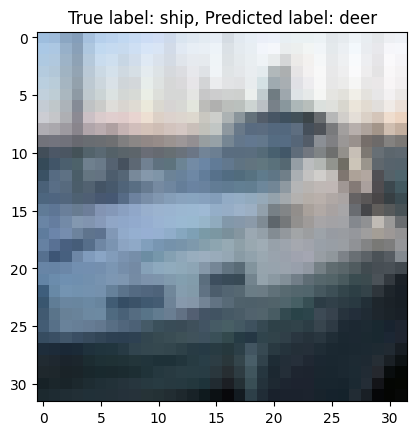

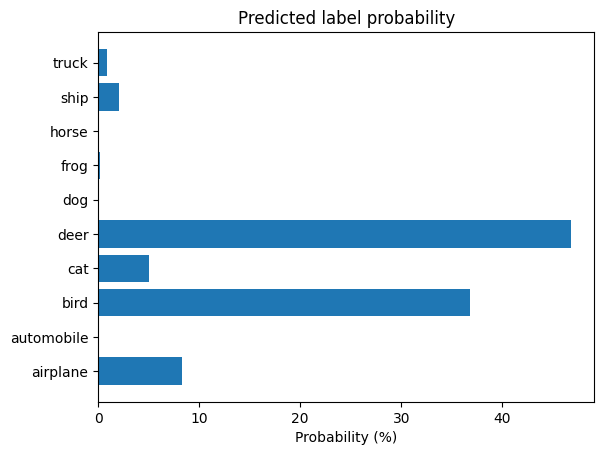

(tensor([8.2558e+00, 2.5315e-02, 3.6771e+01, 4.9937e+00, 4.6773e+01, 2.0590e-02,
         1.6489e-01, 1.9582e-02, 2.0649e+00, 9.1126e-01], device='cuda:0'),
 4,
 8)

In [102]:
get_image_info(2, model, test_dataset, vis = True, bar = True)

In [29]:
import numpy as np
# from the original repo
def perturb_image(xs, index, dataset = test_dataset):
    img = np.array([dataset[index][0]])
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs

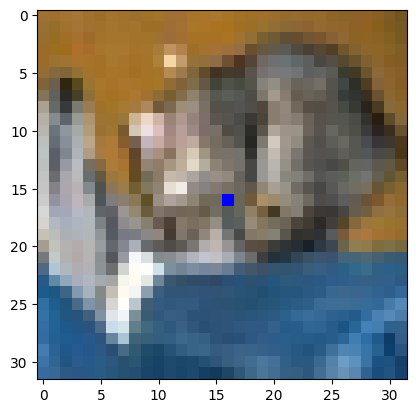

In [30]:
pixel = np.array([16, 16, 0, 0, 255]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel,0)
plt.imshow(image_perturbed[0])

In [66]:
def evaluate(candidates, index, label, model):
    preds = []
    with torch.no_grad():
        for i, xs in enumerate(candidates):
            p_img = perturb_image(xs, index)
            p_img = torch.tensor(p_img).permute(0, 3, 1, 2).to(device).float()
            preds.append(F.softmax(model(p_img).squeeze(), dim=0)[label].item())
    return np.array(preds)

In [78]:
import numpy as np
from tqdm import tqdm

def evolve(candidates):
    """
    Evolve a population of candidates using differential evolution.

    Args:
    candidates (np.array): Array of candidate solutions.
    F (float): Differential weight (scaling factor for the difference vector).

    Returns:
    np.array: Evolved population of candidates.
    """
    gen2 = candidates.copy()
    num_candidates = len(candidates)
    for i in range(num_candidates):
        # Randomly select three distinct candidates
        x1, x2, x3 = candidates[np.random.choice(num_candidates, 3, replace=False)]
        
        # Generate a new candidate using differential evolution formula
        x_next = (x1 + 0.5 *(x2 - x3))
        

        # Resample out-of-bounds values
        x_oob_xy = np.logical_or((x_next[:2] < 0), (31 < x_next[:2]))
        x_oob_rgb = np.logical_or((x_next[2:] < 0), (255 < x_next[2:]))
        x_next[:2][x_oob_xy] = np.random.randint(0, 32, size=np.sum(x_oob_xy))
        x_next[2:][x_oob_rgb] = np.random.randint(0, 256, size=np.sum(x_oob_rgb))
        gen2[i] = x_next
    return gen2

def attack(model, index, true_label, target_label=None, iters=100, pop_size=400, verbose=True):
    """
    Perform a one-pixel adversarial attack on the given model.

    Args:
    model: The target model to attack.
    index: Index of the image to attack.
    true_label: True label of the image.
    target_label: Target label for targeted attack (None for untargeted attack).
    iters (int): Maximum number of iterations.
    pop_size (int): Population size for the evolutionary algorithm.
    verbose (bool): Whether to print progress information.

    Returns:
    tuple: (success (bool), best_solution (np.array), best_score (float))
    """
    # Initialize population of candidates
    candidates = np.zeros((pop_size, 5))
    candidates[:, :2] = np.random.randint(0, 32, size=(pop_size, 2))  # x, y coordinates (0-31)
    candidates[:, 2:] = np.random.randint(0, 256, size=(pop_size, 3))  # RGB values (0-255)
    
    is_targeted = target_label is not None
    label = target_label if is_targeted else true_label
    
    # Evaluate initial population
    fitness = evaluate(candidates, index, label, model)
    
    def is_success():
        """Check if the attack is successful based on the fitness scores."""
        return (is_targeted and fitness.max() > 0.5) or ((not is_targeted) and fitness.min() < 0.05)
    
    # Main evolution loop
    for iteration in tqdm(range(iters), desc='Attacking', leave=True):
        if is_success():
            break
        
        # Print progress if verbose
        if verbose and iteration % 10 == 0:
            print("Target Probability [Iteration {}]:".format(iteration), 
                  fitness.max() if is_targeted else fitness.min())
        
        # Evolve population
        new_gen_candidates = evolve(candidates)
        new_gen_fitness = evaluate(new_gen_candidates, index, label, model)
        
        # Select successful candidates
        successors = new_gen_fitness > fitness if is_targeted else new_gen_fitness < fitness
        candidates[successors] = new_gen_candidates[successors]
        fitness[successors] = new_gen_fitness[successors]
    
    # Find the best solution
    best_idx = fitness.argmax() if is_targeted else fitness.argmin()
    best_solution = candidates[best_idx]
    best_score = fitness[best_idx]
    
    return is_success(), best_solution, best_score

In [80]:
index = 0
_, _, label = get_image_info(index, model, test_dataset, verbose=True)
success, solution, score = attack(model, index, label, target_label=7, iters=100, pop_size=400)

True label index: 3 | Predicted label index: 3
True label: cat | Predicted label: cat


Attacking:   0%|          | 0/100 [00:00<?, ?it/s]

Target Probability [Iteration 0]: 4.463093089546177e-12


Attacking:  10%|█         | 10/100 [00:42<06:13,  4.15s/it]

Target Probability [Iteration 10]: 1.0885216852329904e-06


Attacking:  20%|██        | 20/100 [01:29<05:45,  4.32s/it]

Target Probability [Iteration 20]: 1.0885216852329904e-06


Attacking:  30%|███       | 30/100 [02:14<05:10,  4.44s/it]

Target Probability [Iteration 30]: 1.0885216852329904e-06


Attacking:  40%|████      | 40/100 [03:00<04:29,  4.49s/it]

Target Probability [Iteration 40]: 8.292045822599903e-05


Attacking:  44%|████▍     | 44/100 [03:17<04:11,  4.50s/it]


Text(0.5, 1.0, 'Predicted label probability')

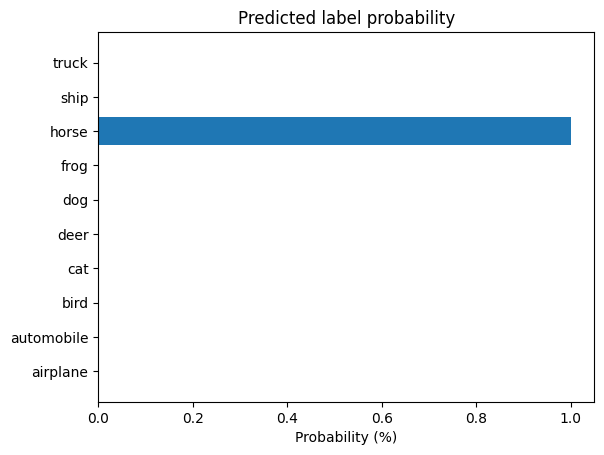

In [94]:
image_perturbed = perturb_image(solution,0)
image_perturbed = torch.tensor(image_perturbed).permute(0, 3, 1, 2).to(device).float()
prob = F.softmax(model(image_perturbed).squeeze(), dim=0)
# plot probability bar
fig, ax = plt.subplots()
ax.barh(test_dataset.classes, prob.cpu().detach().numpy())
ax.set_xlabel('Probability (%)')
ax.set_title('Predicted label probability')